# ECE 570 Assignment 4 Exercise

Your Name: Sai V. Mudumba

## Exercise 1: Creating an image denoiser using a CNN autoencoder.
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Add code to `ConcatDataset` dataloader class that will form a paired dataset that contains a noisy image and its original image. i.e Your concatenated dataset should output noisy image and original image just like what image and label is getting extracted from our previous MNIST dataloader. **Note: Your code should not be the same with the instruction since the instruction have paired dataset that contains the labels; here you should only contains the images.**
3. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In [1]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean, std):
    super(AddGaussianNoise, self).__init__()
    self.mean = mean
    self.std = std
  
  def __call__(self, tensor):
    tensor = tensor + np.random.normal(self.mean, self.std, size=[1,28,28]) # this part is important, esp defining the size
    tensor = np.clip(tensor,0,1)
    return tensor
  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


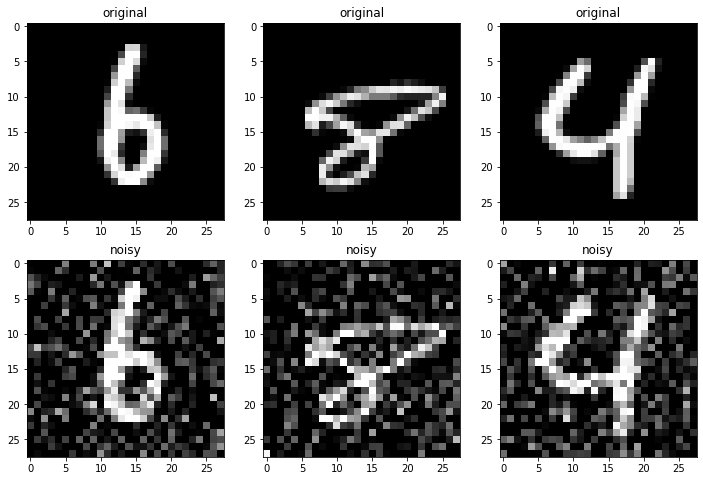

In [2]:
class ConcatDataset(torch.utils.data.Dataset):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    tmp1 = tuple(d[i] for d in self.datasets)
    tmp2 = tuple([tmp1[0][0], tmp1[1][0]])
    return tmp2
  
  def __len__(self):
    return min(len(d) for d in self.datasets)
  #########################  <END YOUR CODE>  ############################

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
_, (noisy_train, original_train) = next(enumerate(train_loader))
noisy_train = [noisy_train]
original_train = [original_train]
     
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[1,idx].imshow(noisy_train[0][idx][0], cmap='gray')
  ax[1,idx].set_title(f'noisy')
  ax[0,idx].imshow(original_train[0][idx][0], cmap='gray')
  ax[0,idx].set_title(f'original')

fig.show()
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [5]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

latent_feature = 16

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()
    
    # encoder
    self.conv1 = nn.Conv2d(1, 15, kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(15, latent_feature, kernel_size=2, stride=2)

    # decoder
    self.tran_conv2 = nn.ConvTranspose2d(latent_feature, 15, kernel_size=2, stride=2)
    self.tran_conv1 = nn.ConvTranspose2d(15, 1, kernel_size=2, stride=2)


  def forward(self, x):

    # encoding layers
    x = self.conv1(x)
    print(x.shape)
    x = F.relu(self.conv2(x))
    print(x.shape)
    
    # decoding layers
    z = x
    z = self.tran_conv2(z)
    print(z.shape)
    z = self.tran_conv1(z) 
    print(z.shape)
    return z


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

#########################  <END YOUR CODE>  ############################

In [6]:
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, original) in enumerate(train_loader): # Note that we do not need the labels
    optimizer.zero_grad()

    images = images.to(device).float()
    original = original.to(device).float()

    output = AE(images)
    loss = loss_fn(output, original) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, orign in test_loader:
      images = images.to(device).float()
      orign = orign.to(device).float()
      output = AE(images)
      test_loss += loss_fn(output, orign).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 4

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Streaming output truncated to the last 5000 lines.
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 1, 28, 28])
torch.Size([64, 15, 14, 14])
torch.Size([64, 16, 7, 7])
torch.Size([64, 20, 14, 14])
torch.Size([64, 

KeyboardInterrupt: ignored

torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


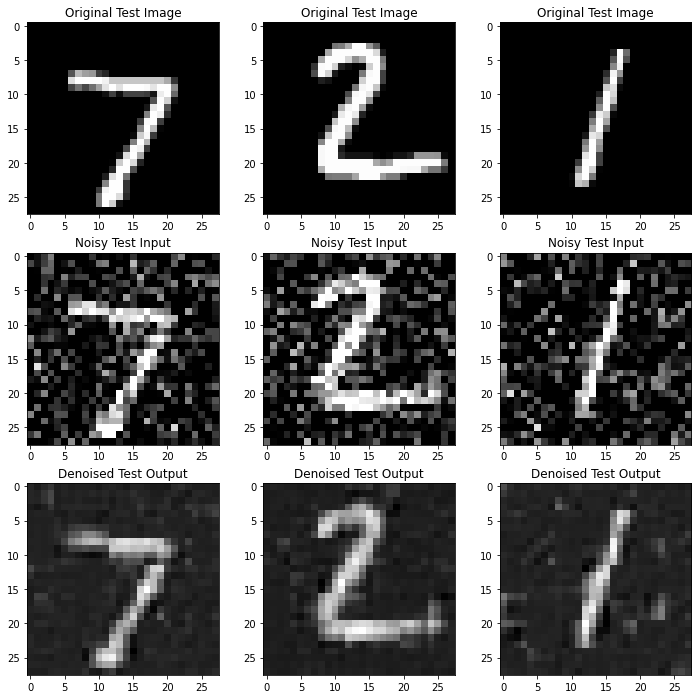

In [ ]:
import matplotlib.pyplot as plt

batch_idx, (images, original_test) = next(enumerate(test_loader))
imagesN = images.to(device).float()
output = AE(imagesN).cpu().detach()
imagesN = imagesN.cpu()

print(imagesN.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)

for idx in range(3):
  ax[0,idx].imshow(original_test[idx][0], cmap='gray') 
  ax[0,idx].set_title('Original Test Image')
  ax[1,idx].imshow(imagesN[idx][0], cmap='gray')
  ax[1,idx].set_title('Noisy Test Input')
  ax[2,idx].imshow(output[idx][0], cmap='gray')
  ax[2,idx].set_title('Denoised Test Output')
fig.show()

## Exercise 2: Build a variational autoencoder that can generate MNIST images

### Task 1: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Print the size of your training and test images.

In [ ]:
###########################   <YOUR CODE>  ############################
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset,
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                      batch_size=batch_size_test, shuffle=False)

print(f'Size of the Training Images: {batch_size_train}')
print(f'Size of the Test Images: {batch_size_test}')

#########################  <END YOUR CODE>  ############################

Size of the Training Images: 64
Size of the Test Images: 1000


### Task 2: VAE model
Build the VAE (variational autoencoder) model. The general code skeleton is provided here, so you only need to complete the functions in the networks.
(You may need to import certain packages before this code getting implemented)
1. Inside the `reparameterize` function you job is to output a latent vector.You should first calculate the standard deviation `std` from the log value of var `log_var`, then generate the vector in Gaussian distribution with `mu` and `std`. 
2. Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math

latent_feature = 16

class our_VAE(nn.Module):
  def __init__(self):
    super(our_VAE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature*2)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var)
    """
    ###########################   <YOUR CODE>  ############################
    
    std = torch.exp(log_var) **0.5
    eps = torch.randn_like(std)
    sample = eps.mul(std).add(mu)

    #########################  <END YOUR CODE>  ############################
    return sample

  
  def forward(self, x):
    """
    :param x: input variables

    You should return a sample with gaussian distribution N(mu, var)
    """
    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = self.en_fc2(x).view(-1,2,latent_feature)

    ###########################   <YOUR CODE>  ############################
    # Extract mu and log_var from x
    mu, log_var = torch.chunk(x,2,1) # this is where I had most issue
    mu = mu.view(-1,16)
    log_var = log_var.view(-1,16)
    
    #########################  <END YOUR CODE>  ############################
    z = self.reparameterize(mu, log_var)

    # decoding layers
    x = F.relu(self.de_fc1(z))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    
    return x, mu, log_var

### Task 3: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
Basically you need to calculate two part and then add them together.
While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
This reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See `torch.nn.functional.binary_cross_entropy` https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy.
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If both are Gaussian, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$  

The class slides provide some derivation of this.  You can also look at the original paper or this blog post for some more information: [Variational Autoencoder](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

Your task here is simply write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var, and returns the loss.


In [ ]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  loss_recon = torch.nn.functional.binary_cross_entropy(output.view(-1,784),images.view(-1,784),size_average=False) # this is where I had most issue
  loss_reg = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))

  loss = loss_recon + loss_reg 
  #print(f'LOSS RECONST: {loss_recon} and LOSS REGUL: {loss_reg}')
  #########################  <END YOUR CODE>  ############################
  return loss

### Task 4: Train and visualize output
1. Train your model with an appropriate optimizer and above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should show at three pairs of images where each pair consists of an original test image and its VAE reconstructed version.


In [ ]:
VAE = our_VAE()
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

In [ ]:
###########################   <YOUR CODE>  ############################
def train(epoch):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels
    optimizer.zero_grad()
    #print(batch_idx)
    images = images.float()
    #print(f'IMAGE SIZE: {images.size()}')
    output, mu, log_var  = VAE(images)
    loss = vae_loss(output, mu, log_var, images) # VAE loss function
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.float()
      output, mu, log_var = VAE(images)
      test_loss += vae_loss(output, mu, log_var, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 4

for epoch in range(1, max_epoch+1):
  train(epoch)
  test(epoch)
#########################  <END YOUR CODE>  ###########################

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1: [0/60000] Loss: 134.843505859375
Epoch 1: [6400/60000] Loss: 135.265380859375
Epoch 1: [12800/60000] Loss: 134.8075408935547
Epoch 1: [19200/60000] Loss: 138.4586181640625
Epoch 1: [25600/60000] Loss: 134.310302734375
Epoch 1: [32000/60000] Loss: 142.20834350585938
Epoch 1: [38400/60000] Loss: 128.3352813720703
Epoch 1: [44800/60000] Loss: 136.55691528320312
Epoch 1: [51200/60000] Loss: 131.34060668945312
Epoch 1: [57600/60000] Loss: 130.7255859375
Test result on epoch 1: Avg loss is 129.36566953125
Epoch 2: [0/60000] Loss: 125.87379455566406
Epoch 2: [6400/60000] Loss: 129.76358032226562
Epoch 2: [12800/60000] Loss: 133.20799255371094
Epoch 2: [19200/60000] Loss: 134.44696044921875
Epoch 2: [25600/60000] Loss: 125.4035873413086
Epoch 2: [32000/60000] Loss: 132.00267028808594
Epoch 2: [38400/60000] Loss: 124.59564208984375
Epoch 2: [44800/60000] Loss: 130.8129119873047
Epoch 2: [51200/60000] Loss: 128.17677307128906
Epoch 2: [57600/60000] Loss: 117.5105972290039
Test result on

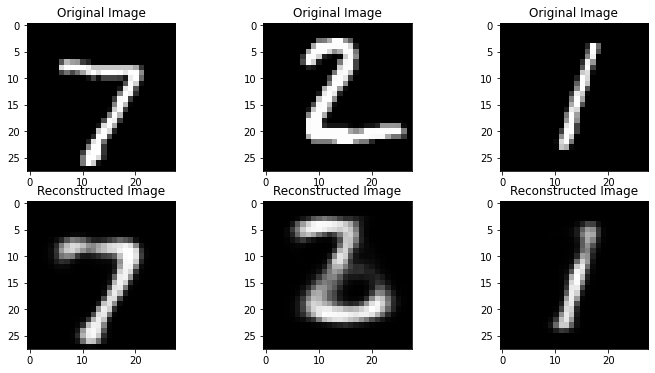

In [ ]:
import matplotlib.pyplot as plt

batch_idx, (images, original_test) = next(enumerate(test_loader))
imagesN = images.float()
output, _, _ = VAE(imagesN)
output = output.detach().numpy()

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(imagesN[idx][0], cmap='gray')
  ax[0,idx].set_title('Original Image')
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  ax[1,idx].set_title('Reconstructed Image')
fig.show()